<a href="https://colab.research.google.com/github/Dolphey/portfolio/blob/main/Copy_of_CapstoneProjectDiscoveryVGG16_Organized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
###Prep

#import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import cv2
import os
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.models import load_model, clone_model
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt


#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# All paths start with this
base_path = '/content/drive/MyDrive/MURA_ELBOW_RESIZED/'

# Load the CSV files
train_df = pd.read_csv('/content/drive/MyDrive/resized_elbow_train_labeled.csv', names=['path', 'label'])
val_df = pd.read_csv('/content/drive/MyDrive/resized_elbow_val_labeled.csv', names=['path', 'label'])
print('Count of training data samples: ','\n', train_df['path'].count(),sep='')
print('Count of training data samples: ','\n',val_df['path'].count(),'\n\n',sep='' )



###Load and preprocess images function


def load_and_preprocess_image(image_path, augment=False):
    #Grayscale images
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        return None

    #Resize the image to 224x224 to fit in a tensor
    img_resized = cv2.resize(img, (224, 224))

    # Apply Gaussian blur
    img_blurred = cv2.GaussianBlur(img_resized, (5, 5), 0)

    # Apply Canny edge detection
    img_edges = cv2.Canny(img_blurred, threshold1=0, threshold2=15)

    #Stack the three types of images together into one array
    img_stack = np.stack([img_resized, img_blurred, img_edges], axis=-1)

    #Convert into a tensor
    img_tensor = tf.convert_to_tensor(img_stack, dtype=tf.float32)

    # Normalizing the image data values
    img_tensor = img_tensor / 255.0

    # Making sure the shape is correct for tensor
    img_tensor.set_shape([224, 224, 3])

    return img_tensor.numpy()



###Generate images function


#Calls the load and preprocess image function on the picture
def generate_images(dataframe, batch_size=32, shuffle=True, augment_data=False):
    #Amount of images in the dataframe
    total_images = len(dataframe)
    while True:
        #Shuffles the images so that the training data is more randomly distributed
        if shuffle:
            dataframe = dataframe.sample(frac=1, random_state=42).reset_index(drop=True)

        #Splits the data into batches
        for i in range(0, total_images, batch_size):
            batch_df = dataframe.iloc[i:i+batch_size]
            images = []
            labels = []

            #Gets the image path and the label
            for idx, row_series in batch_df.iterrows():
                img_path = os.path.join(base_path, row_series['path'])
                label = row_series['label']

                if not os.path.exists(img_path):
                    continue

                img = load_and_preprocess_image(img_path, augment=augment_data)

                if img is not None:
                    images.append(img)
                    labels.append(label)

            #Makes sure no empty batches go to the model
            if len(images) > 0 and len(labels) > 0:
                yield np.array(images), np.array(labels)
            else:
                pass



###Creating the model


BATCH_SIZE = 8

# Create the training and validation generators
train_generator = generate_images(
    train_df,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment_data=True)

val_generator = generate_images(
    val_df,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment_data=False)

# Use grayscale images — convert to 3 channels by repeating
def preprocess_input_grayscale(img):
    return tf.image.grayscale_to_rgb(img)

#Loading the pretrained VGG16 model
vgg_base = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)  )

# Freeze the base
vgg_base.trainable = False

# CNN model - has binary output
model = models.Sequential([
    layers.InputLayer(shape=(224, 224, 3)),
    vgg_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model architecture
model.summary()



###Functions to use while running the model


#Prints the stats at the end of every epoch
class EpochLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_loss_str = f"{logs.get('val_loss', float('nan')):.4f}"
        val_accuracy_str = f"{logs.get('val_accuracy', float('nan')):.4f}"
        print(f"\nEpoch {epoch+1} completed. Validation loss: {val_loss_str}, Validation accuracy: {val_accuracy_str}")
        print("-" * 50)
epoch_logger = EpochLogger()

#will stop the model early if the model has not improved after the patience amount of epochs and restore the best weights
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=200,
    restore_best_weights=True,
    verbose=1)

#Get's the amount of batches in the dataset
steps_per_epoch_train = math.ceil(len(train_df) / BATCH_SIZE)
steps_per_epoch_val = math.ceil(len(val_df) / BATCH_SIZE)

print(f"\n\nTraining steps per epoch: {steps_per_epoch_train}")
print(f"Validation steps per epoch: {steps_per_epoch_val}")


#Ensemble model
def train_and_save_ensemble_models(base_model, train_df, generate_images, save_dir, n_models=20, subset_fraction=0.8, batch_size=32):
    os.makedirs(save_dir, exist_ok=True)

    for i in range(n_models):
        print(f"\n🔁 Training model {i+1}/{n_models}...")

        #Random subset of training data
        subset_df = train_df.sample(frac=subset_fraction, replace=True, random_state=i)

        #Clone and compile the base model
        new_model = clone_model(base_model)
        new_model.set_weights(base_model.get_weights())
        new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        #Create generator
        gen = generate_images(subset_df, batch_size=batch_size, shuffle=True, augment_data=True)
        steps = int(np.ceil(len(subset_df) / batch_size))

        #Train the model for 2 epochs
        new_model.fit(gen, steps_per_epoch=steps, epochs=2, verbose=1)

        #Save the model
        save_path = os.path.join(save_dir, f'elbow_ensemble_model_{i+1}.keras')
        new_model.save(save_path)
        print(f"✅ Saved model {i+1} to: {save_path}")




###Functions for validation

#Confusion matrix
def plot_confusion_matrix(cm, class_names,):
    fig, ax = plt.subplots(figsize=(5, 4))
    ax.matshow(cm, cmap='Greys', alpha=1.0)  # Black/white style
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c = cm[i, j]
            ax.text(j, i, str(c), va='center', ha='center', color='hotpink', fontsize=20)

    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_title('Confusion Matrix', pad=10)
    plt.tight_layout()
    plt.show()

#ROC Curve
def plot_roc_curve(fpr, tpr, roc_auc):
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, color='hotpink', lw=2, label='Model 2 (AUC = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Classifier (AUC = 0.50)')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate (1 - Specificity)')
  plt.ylabel('True Positive Rate (Recall)')
  plt.title('ROC Curve – Elbow Fracture Detection')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Count of training data samples: 
1754
Count of training data samples: 
158




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)



Training steps per epoch: 220
Validation steps per epoch: 20


In [2]:
#Run the code block above, and then this one to fit the model!
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=2000,
    validation_data=val_generator,
    validation_steps=steps_per_epoch_val,
    callbacks=[epoch_logger, early_stopping])

#Evaluate on the validation data
val_loss, val_accuracy = model.evaluate(val_generator, steps=steps_per_epoch_val)
print(f"\nValidation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

#Save the model
model_save_path = '/content/drive/MyDrive/elbow_fracture_model5.h5' # Save to your Google Drive
model.save(model_save_path)
print(f"\nModel saved to: {model_save_path}")

KeyboardInterrupt: 

In [ ]:
#Run the first code block and then this one to create ensemble model
model = load_model('/content/drive/MyDrive/elbow_fracture_model2.h5', compile=False)
train_and_save_ensemble_models(
    base_model=model,
    train_df=train_df,
    generate_images=generate_images,
    save_dir='/content/drive/MyDrive/ensemble_models2',
    n_models=20,
    subset_fraction=0.2,
    batch_size=8
)


🔁 Training model 1/20...
Epoch 1/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.6650 - loss: 0.5745
Epoch 2/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 101s 818ms/step - accuracy: 0.6696 - loss: 0.5619
✅ Saved model 1 to: /content/drive/MyDrive/ensemble_models2/elbow_ensemble_model_1.keras

🔁 Training model 2/20...
Epoch 1/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.6658 - loss: 0.5756
Epoch 2/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 100s 805ms/step - accuracy: 0.6799 - loss: 0.5446
✅ Saved model 2 to: /content/drive/MyDrive/ensemble_models2/elbow_ensemble_model_2.keras

🔁 Training model 3/20...
Epoch 1/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.6799 - loss: 0.5627
Epoch 2/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 99s 799ms/step - accuracy: 0.6874 - loss: 0.5487
✅ Saved model 3 to: /content/drive/MyDrive/ensemble_models2/elbow_ensemble_model_3.keras

🔁 Training model 4/20...
Epoch 1/2
124/124 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6696 - loss: 0.5810
Epoch 2/2
124/124 ━

In [5]:
#Get metrics for the models

#Make a full path column
val_df['full_path'] = val_df['path'].apply(lambda p: os.path.join(base_path, p))

# # Preprocess all test images - This is not needed if using the generator
# X_test_list = [load_and_preprocess_image(p) for p in val_df['full_path']]
# # Filter out None values if any image failed to load
# X_test_list = [img for img in X_test_list if img is not None]
# X_test = np.array(X_test_list).astype(np.float32) # Convert to float32

# # Ensure y_test has the same number of samples as X_test and is the correct type - This is not needed if using the generator
# y_test = val_df['label'].values[:len(X_test_list)].astype(np.float32) # Convert to float32

#Resets the val_generator
val_generator_eval = generate_images(
    val_df,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment_data=False)

#Load model1
#model1 = load_model('/content/drive/MyDrive/elbow_fracture_model1.h5', compile=False)
#model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Load model2
model2 = load_model('/content/drive/MyDrive/elbow_fracture_model2.h5', compile=False)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#print('Model 1') #Trained for about 20 epochs. The threshold for the canny edge detector was set too high so the canny edge detector did not show any edges.
#loss1, accuracy1 = model1.evaluate(val_generator_eval, steps=steps_per_epoch_val)
print('Model 2') #Trained for about 20 epochs. Correct threshold for canny edge detector.
loss2, accuracy2 = model2.evaluate(val_generator_eval, steps=steps_per_epoch_val)


# To get predictions for the entire validation set using the generator:
# Need to iterate through the generator and collect predictions
y_true_list = []
y_pred_probs2_list = []

# Reset the generator for prediction
val_generator_predict = generate_images(
    val_df,
    batch_size=BATCH_SIZE,
    shuffle=False,
    augment_data=False
)

for _ in range(steps_per_epoch_val):
    images, labels = next(val_generator_predict)
    y_true_list.extend(labels)
    y_pred_probs2_list.extend(model2.predict(images).flatten()) # Flatten predictions to match labels

y_test = np.array(y_true_list)
y_pred_probs2 = np.array(y_pred_probs2_list)

Model 2


KeyboardInterrupt: 

In [ ]:
# Assume y_test and y_pred_probs2 are already defined and populated:
# y_test: Your true labels (e.g., from val_df['label'].values)
# y_pred_probs2: The prediction probabilities from your model (e.g., model2.predict(X_test))

# --- Code for F1 curve plotting ---

# Let's create a range of thresholds for the F1 curve
thresholds = np.linspace(0, 1, 101) # 101 points from 0 to 1, covering the full range

precisions_1 = []
recalls_1 = []
f1s_1 = []

# Optional: If you want to plot for Class 0 (No Fracture)
# precisions_0 = []
# recalls_0 = []
# f1s_0 = []

for threshold in thresholds:
    # Convert probabilities to binary predictions based on the current threshold
    y_pred_thresholded = (y_pred_probs2 >= threshold).astype("int33").flatten()

    # Calculate precision, recall, and f1-score for both classes
    # 'average=None' returns scores for each class separately
    # 'labels=[0, 1]' ensures the order is consistent (Class 0, Class 1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_thresholded, average=None, labels=[0, 1]
    )

    # For Class 1 (Fracture)
    # Use .item() to extract scalar values from numpy arrays, or direct indexing
    precisions_1.append(precision[1].item() if len(precision) > 1 else 0)
    recalls_1.append(recall[1].item() if len(recall) > 1 else 0)
    f1s_1.append(f1[1].item() if len(f1) > 1 else 0)

    # Optional: For Class 0 (No Fracture) - uncomment if you want to plot these
    # precisions_0.append(precision[0].item() if len(precision) > 0 else 0)
    # recalls_0.append(recall[0].item() if len(recall) > 0 else 0)
    # f1s_0.append(f1[0].item() if len(f1) > 0 else 0)

plt.figure(figsize=(10, 6))

# Optional: Uncomment and use these if you calculated them for Class 0
# plt.plot(thresholds, precisions_0, label='Precision (Class 0)', linestyle='--', color='teal')
# plt.plot(thresholds, recalls_0, label='Recall (Class 0)', linestyle='-', color='blue')
# plt.plot(thresholds, f1s_0, label='F1-Score (Class 0)', linestyle=':', color='purple')

# Plot for Class 1 (Fracture)
plt.plot(thresholds, precisions_1, label='Precision (Class 1)', linestyle='--', color='hotpink')
plt.plot(thresholds, recalls_1, label='Recall (Class 1)', linestyle='-', color='magenta')
plt.plot(thresholds, f1s_1, label='F1-Score (Class 1)', linestyle=':', color='pink')

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold (Model 2)") # You can change "Model 2" as needed
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


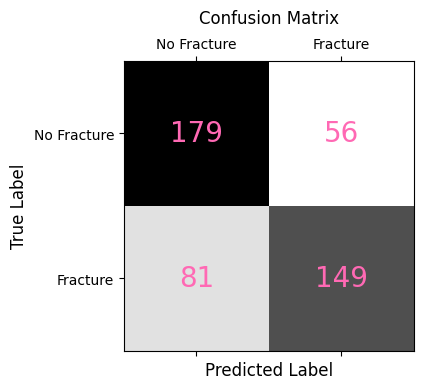

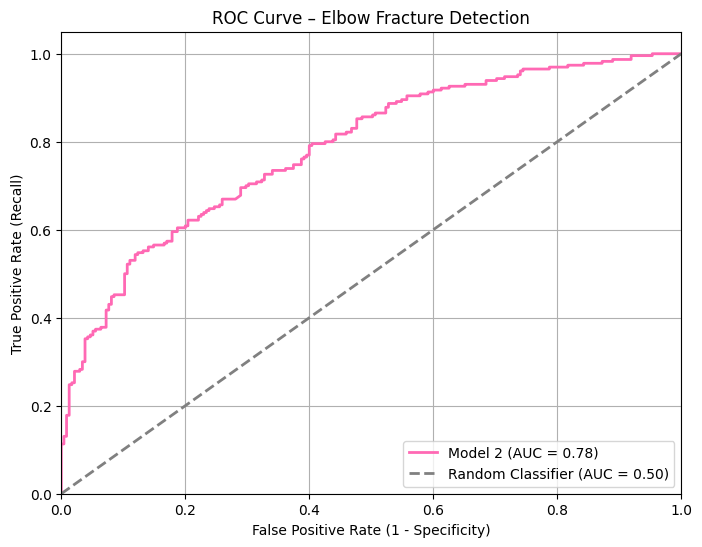

In [ ]:
#Set thresholds
y_pred2_5 = (y_pred_probs2 > 0.50).astype("int32").flatten()

#Get confusion matrix
cm2_5 = confusion_matrix(y_test, y_pred2_5)
plot_confusion_matrix(cm2_5, class_names=["No Fracture", "Fracture"])

#Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs2)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)

#Plot F1 curve
    plt.figure(figsize=(10, 6))

   #plt.plot(thresholds, precisions_0, label='Precision (Class 0)', linestyle='--', color='teal')
   #plt.plot(thresholds, recalls_0, label='Recall (Class 0)', linestyle='-', color='blue')
   #plt.plot(thresholds, f1s_0, label='F1-Score (Class 0)', linestyle=':', color='purple')

    plt.plot(thresholds, precisions_1, label='Precision (Class 1)', linestyle='--', color='hotpink')
    plt.plot(thresholds, recalls_1, label='Recall (Class 1)', linestyle='-', color='magenta')
    plt.plot(thresholds, f1s_1, label='F1-Score (Class 1)', linestyle=':', color='pink')

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision, Recall, F1 vs Threshold (Ensemble)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

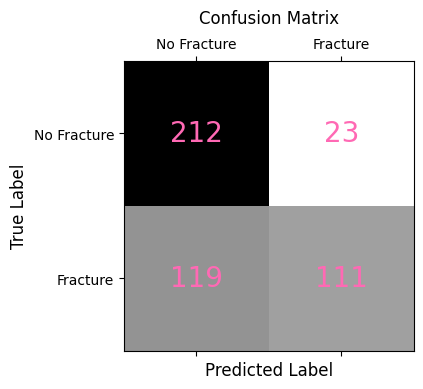

Classification Report (Ensemble, Threshold 0.5):
               precision    recall  f1-score   support

 No Fracture       0.64      0.90      0.75       235
    Fracture       0.83      0.48      0.61       230

    accuracy                           0.69       465
   macro avg       0.73      0.69      0.68       465
weighted avg       0.73      0.69      0.68       465



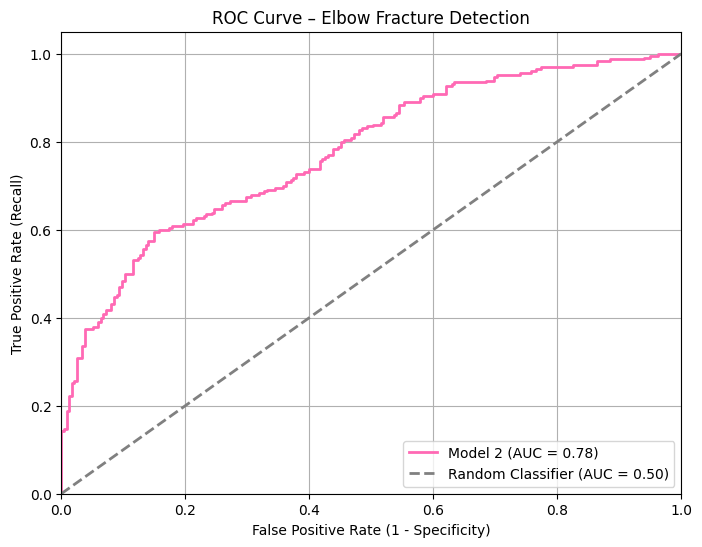

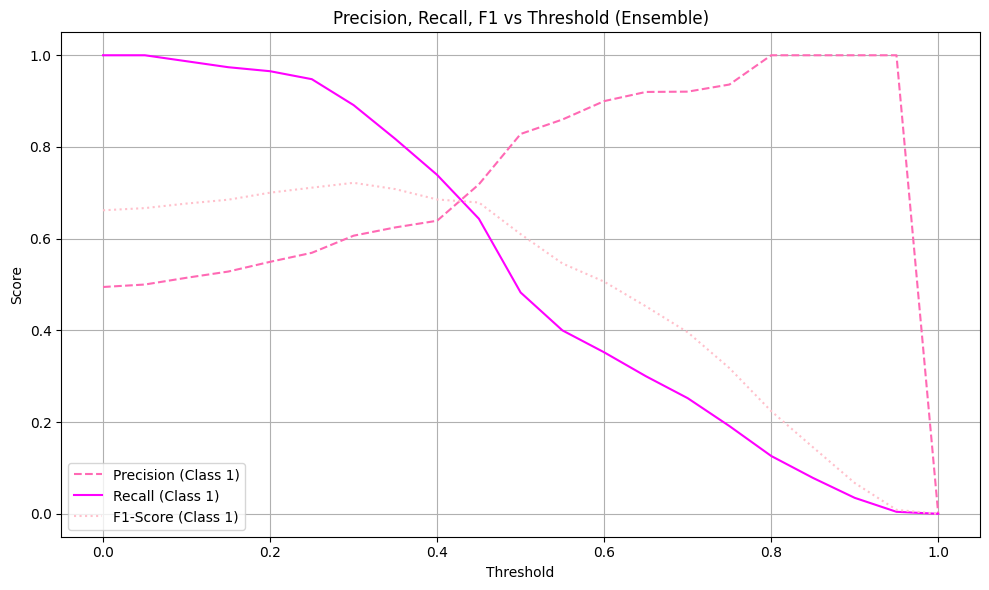

In [ ]:
#Load the model
ensemble_models = []
save_dir = '/content/drive/MyDrive/ensemble_models2' # Define the base directory
n_models = 20 # Define the number of models to load

for i in range(1, n_models + 1):
    path = os.path.join(save_dir, f'elbow_ensemble_model_{i}.keras')
    if not os.path.exists(path):
        print(f"Error: Model not found at {path}")
        continue
    try:
        model = load_model(path)
        ensemble_models.append(model)
    except Exception as e:
        print(f"Error loading model {i}: {e}")

# Check if any models were loaded
if not ensemble_models:
    print("No ensemble models were loaded. Cannot proceed with evaluation.")
else:
    #Get predictions
    # Get all validation data and labels from the generator
    y_true_all = []
    X_val_all = []

    # Reset the validation generator
    val_generator_for_prediction = generate_images(
        val_df,
        batch_size=BATCH_SIZE, # Use the defined BATCH_SIZE
        shuffle=False,
        augment_data=False
    )

    # Use steps_per_epoch_val to iterate through the generator
    for _ in range(steps_per_epoch_val): # Use the defined steps_per_epoch_val
        images, labels = next(val_generator_for_prediction)
        X_val_all.append(images)
        y_true_all.extend(labels)

    X_val_all = np.concatenate(X_val_all, axis=0)
    y_true_all = np.array(y_true_all)


    probs = [model.predict(X_val_all, verbose=0) for model in ensemble_models]
    avg_probs = np.mean(probs, axis=0)

    ensemble_preds_05 = (avg_probs > 0.5).astype(int).flatten()
    cm_ensemble = confusion_matrix(y_true_all, ensemble_preds_05)
    plot_confusion_matrix(cm_ensemble, class_names=["No Fracture", "Fracture"])

    # Classification metrics
    report = classification_report(y_true_all, ensemble_preds_05, target_names=["No Fracture", "Fracture"])
    print("Classification Report (Ensemble, Threshold 0.5):\n", report)
    fpr, tpr, _ = roc_curve(y_true_all, avg_probs)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, roc_auc)

    # === Step 3: Evaluate at multiple thresholds ===
    thresholds = np.arange(0.0, 1.01, 0.05)
    precisions_0, recalls_0, f1s_0 = [], [], []
    precisions_1, recalls_1, f1s_1 = [], [], []

    for thresh in thresholds:
        preds = (avg_probs > thresh).astype(int).flatten()

        for label in [0, 1]:
            precision = precision_score(y_true_all, preds, pos_label=label, zero_division=0)
            recall = recall_score(y_true_all, preds, pos_label=label, zero_division=0)
            f1 = f1_score(y_true_all, preds, pos_label=label, zero_division=0)

            if label == 0:
                precisions_0.append(precision)
                recalls_0.append(recall)
                f1s_0.append(f1)
            else:
                precisions_1.append(precision)
                recalls_1.append(recall)
                f1s_1.append(f1)

    # === Step 4: Plot ===
    plt.figure(figsize=(10, 6))

   #plt.plot(thresholds, precisions_0, label='Precision (Class 0)', linestyle='--', color='teal')
   #plt.plot(thresholds, recalls_0, label='Recall (Class 0)', linestyle='-', color='blue')
   #plt.plot(thresholds, f1s_0, label='F1-Score (Class 0)', linestyle=':', color='purple')

    plt.plot(thresholds, precisions_1, label='Precision (Class 1)', linestyle='--', color='hotpink')
    plt.plot(thresholds, recalls_1, label='Recall (Class 1)', linestyle='-', color='magenta')
    plt.plot(thresholds, f1s_1, label='F1-Score (Class 1)', linestyle=':', color='pink')

    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title("Precision, Recall, F1 vs Threshold (Ensemble)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
#Try the models on a new image
img_path_neg = "drive/MyDrive/MURA-v1.1/valid/XR_ELBOW/patient11414/study1_positive/image2.png"
#img_path_pos = base_path + "valid\XR_ELBOW\patient11205\study1_negative"
imgneg = load_and_preprocess_image(img_path_neg)
imgneg = np.expand_dims(imgneg, axis=0)
print(os.path.exists(img_path_neg))
#imgpos = load_and_preprocess_image(img_path_pos)
#imgpos = np.expand_dims(imgpos, axis=0)

#Get model prediction
prob = model2.predict(imgneg)[0][0]
#prob = model2.predict(imgpos)[0][0]

prob

True
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


np.float32(0.84471714)